## Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [2]:
def load_variants_and_summaries(folder: os.PathLike) -> pd.DataFrame:
    dfs = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.evo'):
                filepath = os.path.join(root, filename)
                variant = os.path.dirname(filepath)[len(folder)+1:]
                df = pd.read_csv(filepath, sep='\t')
                df = df.set_index('generation_id')
                dfs.append((variant, df))
    return dict(dfs)

In [3]:
summary_per_variant = load_variants_and_summaries(folder='../evolution')

In [4]:
[(k, len(v)) for (k, v) in summary_per_variant.items()]

[('atavism=0.25/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.25/pmr=0.1/pma=0.05', 99),
 ('atavism=0.25/pmr=0.1/pma=0.15', 99),
 ('atavism=0.25/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.25/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.25/pmr=0.25/pma=0.05', 99),
 ('atavism=0.25/pmr=0.25/pma=0.15', 99),
 ('atavism=0.25/pmr=0.25/pma=-0.15', 99),
 ('atavism=0.1/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.1/pmr=0.1/pma=0.05', 99),
 ('atavism=0.1/pmr=0.1/pma=0.15', 99),
 ('atavism=0.1/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.1/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.1/pmr=0.25/pma=0.05', 99),
 ('atavism=0.1/pmr=0.25/pma=0.15', 99),
 ('atavism=0.1/pmr=0.25/pma=-0.15', 99),
 ('atavism=0.0/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.0/pmr=0.1/pma=0.05', 99),
 ('atavism=0.0/pmr=0.1/pma=0.15', 99),
 ('atavism=0.0/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.0/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.0/pmr=0.25/pma=0.05', 99),
 ('atavism=0.0/pmr=0.25/pma=0.15', 99),
 ('atavism=0.0/pmr=0.25/pma=-0.15', 99)]

# Probability of Leap

In [42]:
def pool_series(ticks, values, fn):
    out = []
    prev_i = 0
    for i in ticks:
        section = list(values[prev_i:i])
        value = fn(section)
        out.append(value)
        prev_i = i
    return out

def max_pool_series(ticks, values):
    return pool_series(ticks, values, np.max)

def mean_pool_series(ticks, values):
    return pool_series(ticks, values, np.mean)

## Genetic Material over Generations

In [32]:
def plot_genetic_material_over_generations(df: pd.DataFrame, figlen: int = 8):
    
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
        ax.plot(ticks, values, color="#ffffff", marker='o', label=label)

    def annotated_candles(ax, ticks, highs: pd.Series, lows: pd.Series, color: str, label: str):
        highs = mean_pool_series(ticks, highs)
        lows = mean_pool_series(ticks, lows)
        heights = [highs[i] - lows[i] for i in range(len(highs))]
        ax.set_xticks(ticks)
        ax.bar(ticks, height=heights, bottom=lows, width=(max(ticks)/len(ticks)) - 0.5, color=color + 'cc', edgecolor=color, label=label)
        for i, h, l in zip(ticks, highs, lows):
            ax.text(i, h + 0.15, str(round(h, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
            ax.text(i, l - 0.15, str(round(l, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))

    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen/2))
    annotated_candles(ax, ticks, df.genes_max, df.genes_min, color='#58508d', label='genes')
    annotated_area(ax, ticks, df.dna_pool_entropy, color='#003f5c44', label='entropy (dna_pool)')
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('gene counts & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_genetic_material_over_generations(df=summary_per_variant.get('tests'))

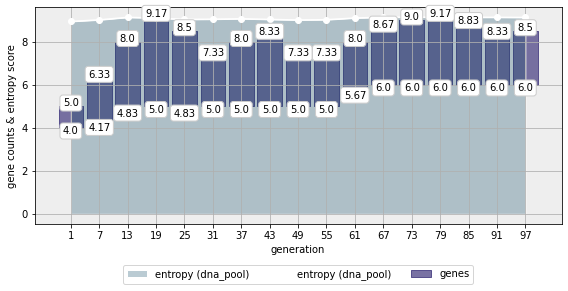

In [33]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.15'))

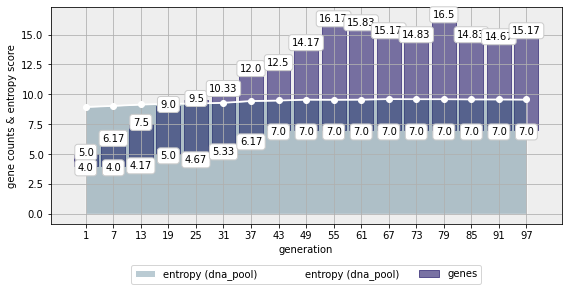

In [34]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'))

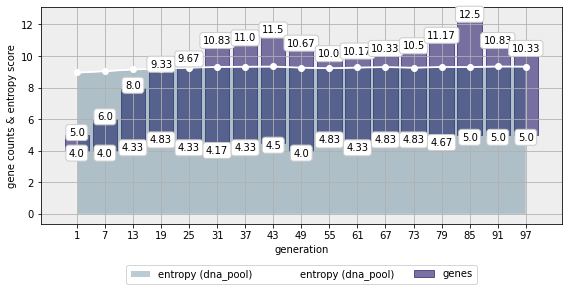

In [35]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'))

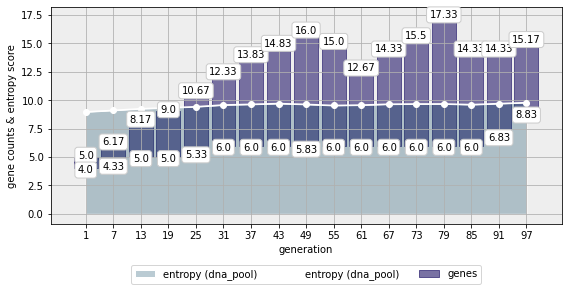

In [36]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.15'))

## Fitness over Generations

In [90]:
def calculate_leap_series(highs: pd.Series) -> pd.Series:
    leaps = []
    for i, high in enumerate(highs):
        seq = highs[0:i]
        leap = 0.
        if i > 0 and len(seq) > 0:
            max_prev_high = max(seq)
            if max_prev_high > 0 and high > max_prev_high:
                leap = 1.
        leaps.append(leap)
    return pd.Series(leaps)

In [118]:
def plot_fitness_over_generations(df: pd.DataFrame, figlen: int = 8):
    from numpy import trapz
    def annotated_line(ax, ticks, values: pd.Series, color: str, label: str, ydist: float = None, pool_type: str = 'mean'):
        values = mean_pool_series(ticks, values) if pool_type else max_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.plot(ticks, values, marker='o', color=color, label=label)
        ydist = max(values) * ydist
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen))
    df['leaps'] = calculate_leap_series(df.fitness_mean)
    
    normalised_leaps = mean_pool_series(ticks, df.leaps)
    print(f"Total Leaps: {len(df[df.leaps > 0])}")
    print(f"DNA Entropy Mean: {float(df.dna_pool_entropy.mean())}")
    print(f"AUC of Leap(|X|): {trapz(normalised_leaps)}")

    annotated_area(ax, ticks, df.dna_pool_entropy, color='#003f5c44', label='entropy (dna_pool)')
    annotated_line(ax, ticks, df.fitness_highest, color='#58508d', label='fitness (highest)', ydist=0.025, pool_type='max')
    annotated_line(ax, ticks, df.fitness_mean, color='#ff6361', label='fitness (mean)', ydist=0.5)
    annotated_line(ax, ticks, df.leaps, color='#ff0000', label='lel(k)', ydist=0.025)
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.125), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('fitness score & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_fitness_over_generations(df=summary_per_variant.get('tests'))

Total Leaps: 8
DNA Entropy Mean: 9.087367448595012
AUC of Leap(|X|): 1.3333333333333333


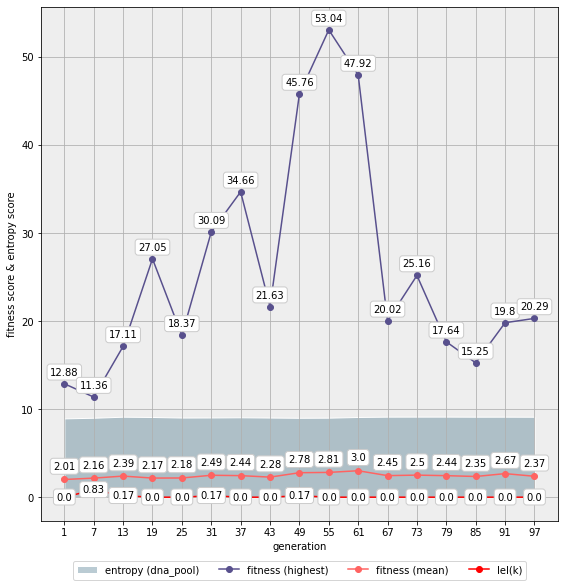

In [119]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.15'))

Total Leaps: 2
DNA Entropy Mean: 9.440349737234703
AUC of Leap(|X|): 0.3333333333333333


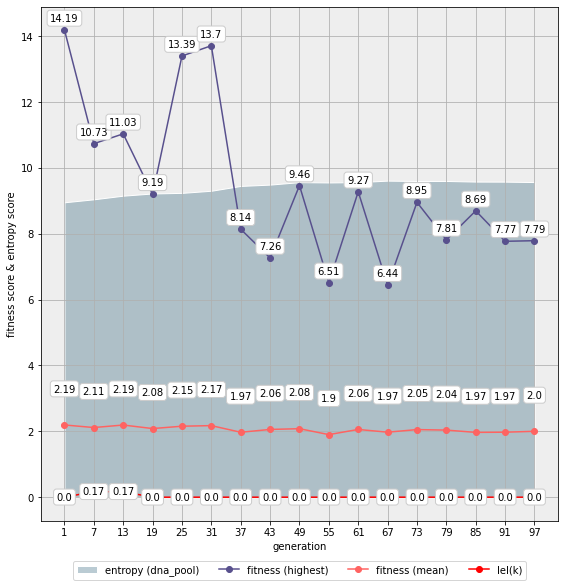

In [120]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'))

Total Leaps: 3
DNA Entropy Mean: 9.270658380745774
AUC of Leap(|X|): 0.8333333333333334


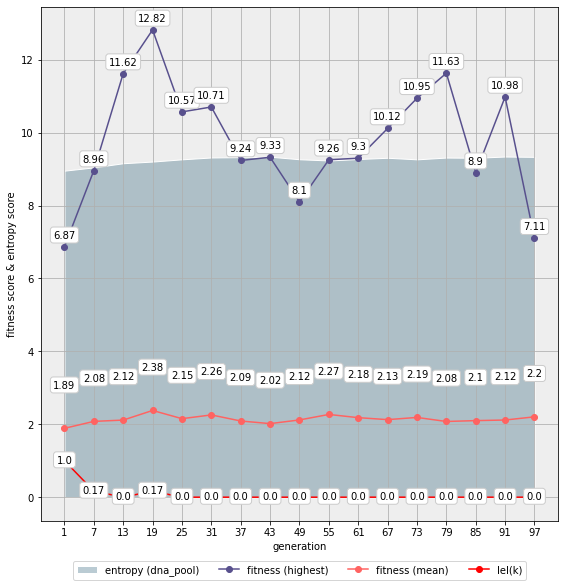

In [121]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'))

Total Leaps: 2
DNA Entropy Mean: 9.54463752353823
AUC of Leap(|X|): 0.6666666666666667


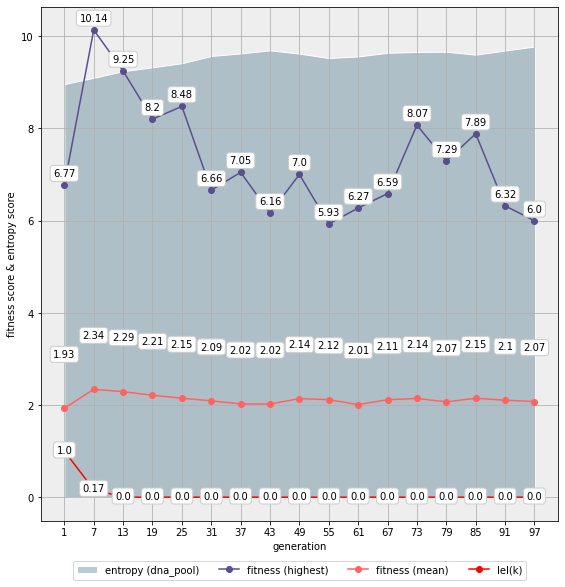

In [122]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.15'))

Total Leaps: 3
DNA Entropy Mean: 9.182428538644134
AUC of Leap(|X|): 0.49999999999999994


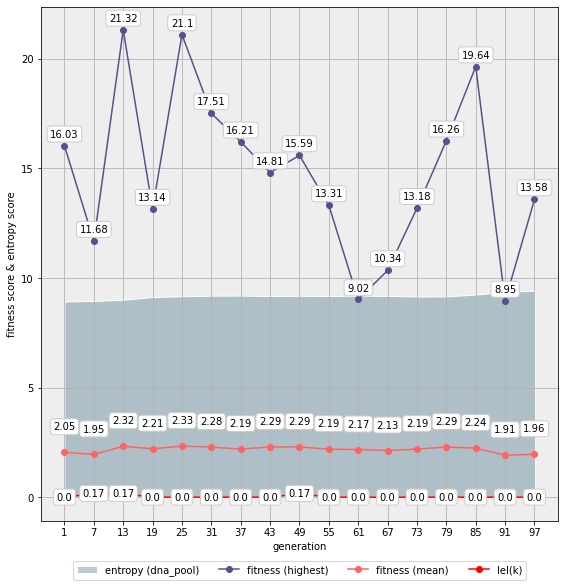

In [123]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.15'))

Total Leaps: 4
DNA Entropy Mean: 9.634745564535917
AUC of Leap(|X|): 0.6666666666666666


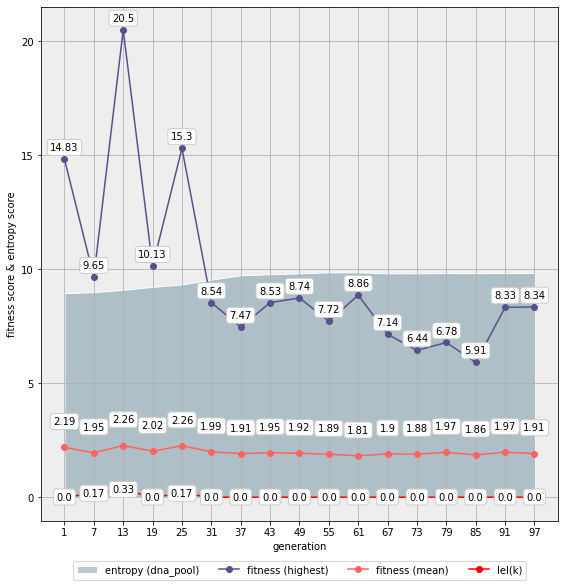

In [124]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.05'))

Total Leaps: 2
DNA Entropy Mean: 9.463933689591729
AUC of Leap(|X|): 0.3333333333333333


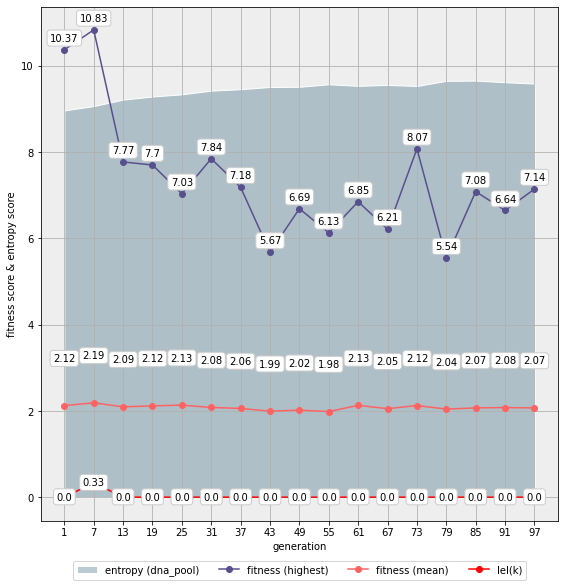

In [125]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.05'))

Total Leaps: 3
DNA Entropy Mean: 9.382824384201196
AUC of Leap(|X|): 0.5


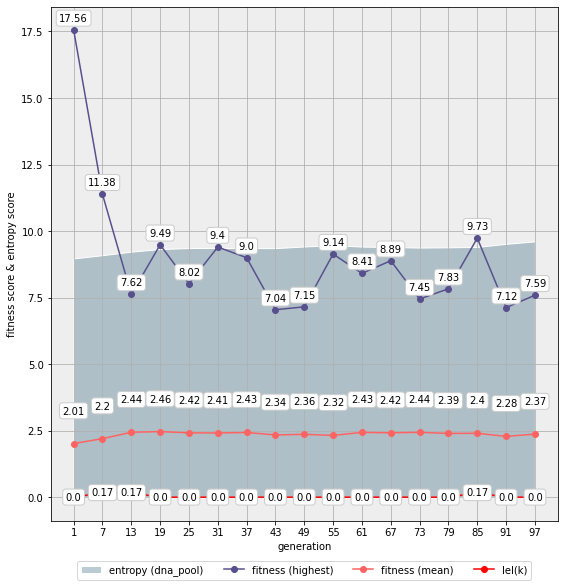

In [126]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.15'))